<a href="https://colab.research.google.com/github/Mityal999/Cars-Classification/blob/main/Cars_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image 
from google.colab import files 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import osи 

from google.colab import drive

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb

from tensorflow.keras.models import load_model

%matplotlib inline

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/UAI_Task_3_auto.zip" -d /content/cars

train_path = '/content/cars/Автомобили/train'
val_path = '/content/cars/Автомобили/val'

img_width = 96
img_height = 54

# AutoKeras

In [ ]:
%%capture
!pip install autokeras

In [ ]:
import autokeras as ak

In [ ]:
imgGen_batch_size = 25

def generate_train_data(batch_size):
    
    datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

    
    train_generator = datagen.flow_from_directory(
        train_path,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    return train_generator
train_gen= generate_train_data(imgGen_batch_size)

def generate_val_data(batch_size):
    
    datagen2 = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=1,
        width_shift_range=0.01,
        height_shift_range=0.01,
        zoom_range=0.01,
        horizontal_flip=False,
        fill_mode='nearest',
    )

    val_generator = datagen2.flow_from_directory(
        val_path,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return val_generator
val_gen = generate_val_data(imgGen_batch_size)

In [ ]:
def data_generator_into_arrays(data_generator):
    x_list = []
    y_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        data = data_generator.next()
        x_list.append(data[0])
        y_list.append(data[1])
        batch_index += 1
    
    x_arr = np.concatenate(x_list, axis=0)
    y_arr = np.concatenate(y_list, axis=0)
    return (x_arr, y_arr)

(x_train, y_train) = data_generator_into_arrays(train_gen)
(x_val, y_val) = data_generator_into_arrays(val_gen)

In [ ]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    block_type='vanilla',
    normalize=False,
    augment=False,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=False, max_trials=5
)

INFO:tensorflow:Reloading Oracle from existing project ./auto_model/oracle.json
INFO:tensorflow:Reloading Tuner from ./auto_model/tuner0.json


In [ ]:
# clf = ak.ImageClassifier(overwrite=True, max_trials=40)

clf.fit(x_train, 
        y_train, 
        validation_data=(x_val, y_val),
        epochs=15)

In [ ]:
model = clf.export_model()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 54, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 96, 54, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 92, 50, 256)       19456     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 12, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 12, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 8, 256)        1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 256)         0     

In [ ]:
export_folder = '/content/drive/MyDrive/'
export_name = 'autokeras_saved_model' + '.h5'
export_path = export_folder + export_name

model.save(export_path)
print('Done!')

Done!


#Ред. модель автокераса

In [ ]:
model = load_model('/content/drive/MyDrive/autokeras_saved_model.h5')

#WANDB Sweep setup  (перебор гиперпараметров)

In [ ]:
#Имя проекта
PROJECT_NAME = "UAI_task_3_uPro"

###__словарь свипа для модели туториала

In [ ]:
# Установка дефолтных параметров свипа
sweep_config = {'method': 'grid'}

sweep_config['parameters'] = {
    'model' : {'value': 'tutorial'}, #new, tutorial, import

    'T1_bs': {'value': 25},
    'T1_lr': {'value': 1e-4},
    'T2_bs': {'value': 25},
    'T2_lr': {'value': 2e-5}, 
    }


# Остальные изменяемые параметры
T1_EPOCHS = 45
T1_ES_PATIENCE = 999

T2_EPOCHS = 30
T2_ES_PATIENCE = 999


# Изменение некоторых дефолтных параметров свипа для перебора по ним
SWEEP_MODE = '0'

# Функция создания списка ничтожно разнящихся learinig_rate-ов (нужна для множественного запуска рана с одинаковыми параметрами)
def static_iteration_on_lr(launches):
    default_lr = sweep_config['parameters']['T1_lr']['value']
    sweep_config['parameters']['T1_lr'] = {'values': [default_lr + default_lr/1000*i  for i in range(launches)]}
if SWEEP_MODE == '0':
    static_iteration_on_lr(1)


# Вывести что получилось
print('T1_EPOCHS = ', T1_EPOCHS)
print('T1_ES_PATIENCE = ', T1_ES_PATIENCE)
print('T2_EPOCHS = ', T2_EPOCHS)
print('T2_ES_PATIENCE = ', T2_ES_PATIENCE)
print('\n')
sweep_config['parameters']

T1_EPOCHS =  45
T1_ES_PATIENCE =  999
T2_EPOCHS =  30
T2_ES_PATIENCE =  999




{'T1_bs': {'value': 25},
 'T1_lr': {'values': [0.0001]},
 'T2_bs': {'value': 25},
 'T2_lr': {'value': 2e-05},
 'model': {'value': 'tutorial'}}

###__словарь свипа для готовой модели

In [ ]:
# Установка дефолтных параметров свипа
sweep_config = {'method': 'grid'}

sweep_config['parameters'] = {
    'model' : {'value': 'import'}, #new, tutorial, import
    'model_path' : {'value': '/content/drive/MyDrive/autokeras_saved_model.h5'},

    'T1_bs': {'value': 16},
    'T1_lr': {'value': 5e-3},
    'T2_bs': {'value': 16},
    'T2_lr': {'value': 1e-4}, 
    }


# Остальные изменяемые параметры
T1_EPOCHS = 30
T1_ES_PATIENCE = 999

T2_EPOCHS = 20
T2_ES_PATIENCE = 999


# Изменение некоторых дефолтных параметров свипа для перебора по ним
SWEEP_MODE = '0'

# Функция создания списка ничтожно разнящихся learinig_rate-ов (нужна для множественного запуска рана с одинаковыми параметрами)
def static_iteration_on_lr(launches):
    default_lr = sweep_config['parameters']['T1_lr']['value']
    sweep_config['parameters']['T1_lr'] = {'values': [default_lr + default_lr/1000*i  for i in range(launches)]}
if SWEEP_MODE == '0':
    static_iteration_on_lr(1)


# Вывести что получилось
print('T1_EPOCHS = ', T1_EPOCHS)
print('T1_ES_PATIENCE = ', T1_ES_PATIENCE)
print('T2_EPOCHS = ', T2_EPOCHS)
print('T2_ES_PATIENCE = ', T2_ES_PATIENCE)
print('\n')
sweep_config['parameters']

T1_EPOCHS =  30
T1_ES_PATIENCE =  999
T2_EPOCHS =  20
T2_ES_PATIENCE =  999




{'T1_bs': {'value': 16},
 'T1_lr': {'values': [0.005]},
 'T2_bs': {'value': 16},
 'T2_lr': {'value': 0.0001},
 'model': {'value': 'import'},
 'model_path': {'value': '/content/drive/MyDrive/autokeras_saved_model.h5'}}

###__словарь свипа для сетки

In [ ]:
# Установка дефолтных параметров свипа
sweep_config = {'method': 'grid'}

sweep_config['parameters'] = {
    'model' : {'value': 'new'}, #new, tutorial, import
    
    'T1_bs': {'value': 25},
    'T1_lr': {'value': 1e-4},
    'T2_bs': {'value': 25},
    'T2_lr': {'value': 1e-5},

    # Conv
    'C1_filters' : {'value' : 64},
    'C1_kernel' : {'value' : 3},
    'C1_strides' : {'value' : 1},
    'C1_poolSize': {'value': 1},
    'C1_do_batch_norm': {'value': False},
    
    
    'C2_filters' : {'value' : 64},
    'C2_kernel' : {'value' : 3},
    'C2_strides' : {'value' : 1},
    'C2_poolSize': {'value': 2},
    'C2_do_batch_norm': {'value': False},


    'C3_filters' : {'value' : 128},
    'C3_kernel' : {'value' : 3},
    'C3_strides' : {'value' : 1},
    'C3_poolSize': {'value': 1},
    'C3_do_batch_norm': {'value': False},

    'C4_filters' : {'value' : 128},
    'C4_kernel' : {'value' : 3},
    'C4_strides' : {'value' : 1},
    'C4_poolSize': {'value': 2},
    'C4_do_batch_norm': {'value': False},
    

    'C5_filters' : {'value' : 128},
    'C5_kernel' : {'value' : 6},
    'C5_strides' : {'value' : 1},
    'C5_poolSize': {'value': 1},
    'C5_do_batch_norm': {'value': False},
    
    'C6_filters' : {'value' : 128},
    'C6_kernel' : {'value' : 6},
    'C6_strides' : {'value' : 1},
    'C6_poolSize': {'value': 6},
    'C6_do_batch_norm': {'value': False},


    'Ci_dropout': {'value': 0.2},

    # Dense
    'D1_neurons' : {'value' : 512},
    'D2_neurons' : {'value' : 0},

    'Di_dropout': {'value': 0.3},    
    }


# Остальные изменяемые параметры
T1_EPOCHS = 45
T1_ES_PATIENCE = 999

T2_EPOCHS = 0
T2_ES_PATIENCE = 999


# Изменение некоторых дефолтных параметров свипа для перебора по ним
SWEEP_MODE = '0'

# Функция создания списка ничтожно разнящихся learinig_rate-ов (нужна для множественного запуска рана с одинаковыми параметрами)
def static_iteration_on_lr(launches):
    default_lr = sweep_config['parameters']['T1_lr']['value']
    sweep_config['parameters']['T1_lr'] = {'values': [default_lr + default_lr/1000*i  for i in range(launches)]}
if SWEEP_MODE == '0':
    static_iteration_on_lr(1)
    
if SWEEP_MODE == '1':
    sweep_config['parameters']['C3_filters'] = {'values': [128,256,512]}
    static_iteration_on_lr(1)



# Вывести что получилось
print('T1_EPOCHS = ', T1_EPOCHS)
print('T1_ES_PATIENCE = ', T1_ES_PATIENCE)
print('T2_EPOCHS = ', T2_EPOCHS)
print('T2_ES_PATIENCE = ', T2_ES_PATIENCE)
print('\n')
sweep_config['parameters']

T1_EPOCHS =  45
T1_ES_PATIENCE =  999
T2_EPOCHS =  0
T2_ES_PATIENCE =  999




{'C1_do_batch_norm': {'value': False},
 'C1_filters': {'value': 64},
 'C1_kernel': {'value': 3},
 'C1_poolSize': {'value': 1},
 'C1_strides': {'value': 1},
 'C2_do_batch_norm': {'value': False},
 'C2_filters': {'value': 64},
 'C2_kernel': {'value': 3},
 'C2_poolSize': {'value': 2},
 'C2_strides': {'value': 1},
 'C3_do_batch_norm': {'value': False},
 'C3_filters': {'value': 128},
 'C3_kernel': {'value': 3},
 'C3_poolSize': {'value': 1},
 'C3_strides': {'value': 1},
 'C4_do_batch_norm': {'value': False},
 'C4_filters': {'value': 128},
 'C4_kernel': {'value': 3},
 'C4_poolSize': {'value': 2},
 'C4_strides': {'value': 1},
 'C5_do_batch_norm': {'value': False},
 'C5_filters': {'value': 128},
 'C5_kernel': {'value': 6},
 'C5_poolSize': {'value': 1},
 'C5_strides': {'value': 1},
 'C6_do_batch_norm': {'value': False},
 'C6_filters': {'value': 128},
 'C6_kernel': {'value': 6},
 'C6_poolSize': {'value': 6},
 'C6_strides': {'value': 1},
 'Ci_dropout': {'value': 0.2},
 'D1_neurons': {'value': 512}

###__словарь свипа для байеса

In [ ]:
def two_pwr_list(a,b):

    return [2**i for i in range(a,b +1)]
def decimal_list(a,b):
    list = [round(x, 1) for x in np.arange(a, b/10, 0.1)]
    arr = np.array(list)
    return arr.tolist()

# Установка дефолтных параметров свипа
sweep_config = {'method': 'bayes'}
sweep_config['metric'] = {'name': 'best_val_loss', 'goal': 'minimize'}

sweep_config['parameters'] = {
    'model' : {'value': 'new'}, #new, tutorial, import

    'T1_bs': {'value': 64},
    'T1_lr': {'value': 8e-4},
    'T2_bs': {'value': 64},
    'T2_lr': {'value': 4e-5},

    # Conv
    'C1_filters' : {'values' : two_pwr_list(5,8) },
    'C2_filters' : {'values' : two_pwr_list(5,8) },
    'C3_filters' : {'values' : two_pwr_list(5,8) },

    'C1_kernel' : {'values' : [2,3,4] },
    'C2_kernel' : {'values' : [2,3,4,6] },
    'C3_kernel' : {'values' : [2,3,4,6,8] },

    'C1_strides' : {'values' : [1,2] },
    'C2_strides' : {'values' : [1,2] },
    'C3_strides' : {'values' : [1,2] },

    'C1_poolSize': {'values': [2,3,4] },
    'C2_poolSize': {'values': [1,2,3,4] },
    'C3_poolSize': {'values': [1,2,3,4] },

    'Ci_dropout': {'value': 0.3},

    # Dense
    'D1_neurons' : {'values' : two_pwr_list(5,9)},
    'D2_neurons' : {'values' : two_pwr_list(5,9)},

    'Di_dropout': {'value': 0.2},    
    }


# Остальные изменяемые параметры
T1_EPOCHS = 30
T1_ES_PATIENCE = 15

T2_EPOCHS = 10
T2_ES_PATIENCE = 5


# Вывести что получилось
print('T1_EPOCHS = ', T1_EPOCHS)
print('T1_ES_PATIENCE = ', T1_ES_PATIENCE)
print('T2_EPOCHS = ', T2_EPOCHS)
print('T2_ES_PATIENCE = ', T2_ES_PATIENCE)
print('\n')
sweep_config['parameters']

T1_EPOCHS =  30
T1_ES_PATIENCE =  15
T2_EPOCHS =  10
T2_ES_PATIENCE =  5




{'C1_filters': {'values': [32, 64, 128, 256]},
 'C1_kernel': {'values': [2, 3, 4]},
 'C1_poolSize': {'values': [2, 3, 4]},
 'C1_strides': {'values': [1, 2]},
 'C2_filters': {'values': [32, 64, 128, 256]},
 'C2_kernel': {'values': [2, 3, 4, 6]},
 'C2_poolSize': {'values': [1, 2, 3, 4]},
 'C2_strides': {'values': [1, 2]},
 'C3_filters': {'values': [32, 64, 128, 256]},
 'C3_kernel': {'values': [2, 3, 4, 6, 8]},
 'C3_poolSize': {'values': [1, 2, 3, 4]},
 'C3_strides': {'values': [1, 2]},
 'Ci_dropout': {'value': 0.3},
 'D1_neurons': {'values': [32, 64, 128, 256, 512]},
 'D2_neurons': {'values': [32, 64, 128, 256, 512]},
 'Di_dropout': {'value': 0.2},
 'T1_bs': {'value': 64},
 'T1_lr': {'value': 0.0008},
 'T2_bs': {'value': 64},
 'T2_lr': {'value': 4e-05},
 'model': {'value': 'new'}}

###__ объявление модели и её обучения

In [ ]:
# Функция обучения модели для рана
def train(input_config=None):

    # Запуск рана
    with wandb.init(config=input_config):
        config = wandb.config
        C = config

        # Подгружаем конфиги
        T1_BS = C.T1_bs
        T1_LR = C.T1_lr

        T2_BS = C.T2_bs
        T2_LR = C.T2_lr


        #Подгружаем данные
        def generate_train_data(batch_size):
            #Генератор изображений
            datagen = ImageDataGenerator(
                rescale=1. / 255, #Значения цвета меняем на дробные показания
                rotation_range=10, #Поворачиваем изображения при генерации выборки
                width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
                height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
                zoom_range=0.1, #Зумируем изображения при генерации выборки
                horizontal_flip=True, #Включаем отзеркаливание изображений
                fill_mode='nearest', #Заполнение пикселей вне границ ввода
            )

            # обучающая выборка
            train_generator = datagen.flow_from_directory(
                train_path, #Путь ко всей выборке выборке
                target_size=(img_width, img_height), #Размер изображений
                batch_size=batch_size, #Размер batch_size
                class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
                shuffle=True #Перемешивание выборки
            )

            return train_generator

        train_gen = generate_train_data(T1_BS)
        train_gen2 = generate_train_data(T2_BS)

        def generate_val_data(batch_size):
            #Генератор изображений
            datagen2 = ImageDataGenerator(
                rescale=1. / 255, #Значения цвета меняем на дробные показания
                rotation_range=1, #Поворачиваем изображения при генерации выборки
                width_shift_range=0.01, #Двигаем изображения по ширине при генерации выборки
                height_shift_range=0.01, #Двигаем изображения по высоте при генерации выборки
                zoom_range=0.01, #Зумируем изображения при генерации выборки
                horizontal_flip=False, #Включаем отзеркаливание изображений
                fill_mode='nearest', #Заполнение пикселей вне границ ввода
            )

            val_generator = datagen2.flow_from_directory(
                val_path, #Путь ко всей выборке выборке
                target_size=(img_width, img_height), #Размер изображений
                batch_size=batch_size, #Размер batch_size
                class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
                shuffle=False #Перемешивание выборки
            )

            return val_generator

        val_gen = generate_val_data(T1_BS)
        val_gen2 = generate_val_data(T2_BS)


        # Объявление модели         
        def create_model():
            model = Sequential()

            # Conv-s
            model.add(Conv2D(C.C1_filters, C.C1_kernel, padding='same', activation='relu', strides=C.C1_strides, input_shape=(img_width, img_height, 3)))
            if C.C1_poolSize > 1: 
                model.add(MaxPooling2D(pool_size=C.C1_poolSize))
            if C.C1_do_batch_norm: 
                model.add(BatchNormalization())
            model.add(Dropout(C.Ci_dropout))
            
            if C.C2_filters > 0:
                model.add(Conv2D(C.C2_filters, C.C2_kernel, padding='same', activation='relu', strides=C.C2_strides))
                if C.C2_poolSize > 1: 
                    model.add(MaxPooling2D(pool_size=C.C2_poolSize))
                if C.C2_do_batch_norm: 
                    model.add(BatchNormalization())
                model.add(Dropout(C.Ci_dropout))

            if C.C3_filters > 0:
                model.add(Conv2D(C.C3_filters, C.C3_kernel, padding='same', activation='relu', strides=C.C3_strides))
                if C.C3_poolSize > 1: 
                    model.add(MaxPooling2D(pool_size=C.C3_poolSize))
                if C.C3_do_batch_norm: 
                    model.add(BatchNormalization())
                model.add(Dropout(C.Ci_dropout))

            if C.C4_filters > 0:
                model.add(Conv2D(C.C4_filters, C.C4_kernel, padding='same', activation='relu', strides=C.C4_strides))
                if C.C4_poolSize > 1: 
                    model.add(MaxPooling2D(pool_size=C.C4_poolSize))
                if C.C4_do_batch_norm: 
                    model.add(BatchNormalization())
                model.add(Dropout(C.Ci_dropout))

            if C.C5_filters > 0:
                model.add(Conv2D(C.C5_filters, C.C5_kernel, padding='same', activation='relu', strides=C.C5_strides))
                if C.C5_poolSize > 1: 
                    model.add(MaxPooling2D(pool_size=C.C5_poolSize))
                if C.C5_do_batch_norm: 
                    model.add(BatchNormalization())
                model.add(Dropout(C.Ci_dropout))

            if C.C6_filters > 0:
                model.add(Conv2D(C.C6_filters, C.C6_kernel, padding='same', activation='relu', strides=C.C6_strides))
                if C.C6_poolSize > 1: 
                    model.add(MaxPooling2D(pool_size=C.C6_poolSize))
                if C.C6_do_batch_norm: 
                    model.add(BatchNormalization())
                model.add(Dropout(C.Ci_dropout))

            # Dense
            model.add(Flatten())
            model.add(Dense(C.D1_neurons, activation='relu'))
            model.add(Dropout(C.Di_dropout))

            if C.D2_neurons > 0: 
                model.add(Dense(C.D2_neurons, activation='relu'))
                model.add(Dropout(C.Di_dropout))

            # Out
            model.add(Dense(len(train_gen.class_indices), activation='softmax'))
            return model
        def create_tutorial_model():
            model = Sequential()
            
            drop1 = 0.1
            drop2 = 0.1
            model.add(Conv2D(256, 4, padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
            # model.add(MaxPooling2D(pool_size=2))            
            model.add(Dropout(drop1))

            model.add(Conv2D(256, 4, padding='same', activation='relu'))
            model.add(MaxPooling2D(pool_size=2))
            model.add(Dropout(drop1))

            model.add(Conv2D(128, 3, padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
            model.add(MaxPooling2D(pool_size=2))            
            model.add(Dropout(drop1))

            model.add(Conv2D(128, 3, padding='same', activation='relu'))
            model.add(MaxPooling2D(pool_size=2))
            model.add(Dropout(drop1))
            
            model.add(Conv2D(256, 8, padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
            model.add(MaxPooling2D(pool_size=2))            
            model.add(Dropout(drop1))

            model.add(Conv2D(256, 8, padding='same', activation='relu'))
            model.add(MaxPooling2D(pool_size=2))
            model.add(Dropout(drop1))

            model.add(Flatten())
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(drop2))
            model.add(Dense(1024, activation='relu'))
            model.add(Dropout(drop2))
            model.add(Dense(len(train_gen.class_indices), activation='softmax'))

            return model

        if C.model == 'import':
            model = load_model(C.model_path)
        if C.model == 'new':
            model = create_model()
        if C.model == 'tutorial':
            model = create_tutorial_model()
            
        print(model.summary())


        # Обучение 1        
        model.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(learning_rate=T1_LR), 
                    metrics=['accuracy'])
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=T1_ES_PATIENCE)
        
        history = model.fit(train_gen, batch_size=T1_BS, 
                            epochs=T1_EPOCHS, verbose=1,
                            validation_data=val_gen, validation_batch_size=T1_BS,
                            validation_steps = val_gen.samples // T1_BS,
                            callbacks=[es, WandbCallback()])
        

        # Обучение 2
        if T2_EPOCHS > 0:
            model.compile(loss='categorical_crossentropy', 
                        optimizer=Adam(learning_rate=T2_LR), 
                        metrics=['accuracy'])            
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=T2_ES_PATIENCE)
            
            history = model.fit(train_gen2, batch_size=T2_BS, 
                            epochs=T2_EPOCHS, verbose=0,
                            validation_data=val_gen2, validation_batch_size=T2_BS,
                            validation_steps = val_gen2.samples // T2_BS,
                            callbacks=[es, WandbCallback()])


        # Экспорт обученной модели
        export_folder = '/content/drive/MyDrive/'
        export_name = 'last_trained_model' + '.h5'
        export_path = export_folder + export_name

        model.save(export_path)


        # Матрица ошибок
        val_true_classes = val_gen.classes
        val_predictions = model.predict(val_gen)
        val_predicted_classes = np.argmax(val_predictions, axis=1)
        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                                                            y_true=val_true_classes, 
                                                            preds=val_predicted_classes,
                                                            class_names=['Ferrari', 'Mercedes', 'Renault'])})
        

        # Номера ошибок
        incorrects = np.nonzero(val_predicted_classes != val_true_classes)
        print(incorrects)
        
            



###__запуск свипа


In [ ]:
# Объявляем свип
sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)
wandb.agent(sweep_id, train)

Create sweep with ID: 6deqy63k
Sweep URL: https://wandb.ai/mityal999/UAI_task_3_uPro/sweeps/6deqy63k


wandb: Agent Starting Run: hq94e9vi with config:
wandb: 	C1_do_batch_norm: False
wandb: 	C1_filters: 64
wandb: 	C1_kernel: 3
wandb: 	C1_poolSize: 1
wandb: 	C1_strides: 1
wandb: 	C2_do_batch_norm: False
wandb: 	C2_filters: 64
wandb: 	C2_kernel: 3
wandb: 	C2_poolSize: 2
wandb: 	C2_strides: 1
wandb: 	C3_do_batch_norm: False
wandb: 	C3_filters: 128
wandb: 	C3_kernel: 3
wandb: 	C3_poolSize: 1
wandb: 	C3_strides: 1
wandb: 	C4_do_batch_norm: False
wandb: 	C4_filters: 128
wandb: 	C4_kernel: 3
wandb: 	C4_poolSize: 2
wandb: 	C4_strides: 1
wandb: 	C5_do_batch_norm: False
wandb: 	C5_filters: 128
wandb: 	C5_kernel: 6
wandb: 	C5_poolSize: 1
wandb: 	C5_strides: 1
wandb: 	C6_do_batch_norm: False
wandb: 	C6_filters: 128
wandb: 	C6_kernel: 6
wandb: 	C6_poolSize: 6
wandb: 	C6_strides: 1
wandb: 	Ci_dropout: 0.2
wandb: 	D1_neurons: 512
wandb: 	D2_neurons: 0
wandb: 	Di_dropout: 0.3
wandb: 	T1_bs: 25
wandb: 	T1_lr: 0.0001
wandb: 	T2_bs: 25
wandb: 	T2_lr: 1e-05
wandb: 	model: new


Found 2743 images belonging to 3 classes.
Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.
Found 684 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 54, 64)        1792      
                                                                 
 dropout (Dropout)           (None, 96, 54, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 54, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 27, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 48, 27, 64)        0         
                      

accuracy,▁▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▂▁▂▂▂▃▃▃▄▄▄▃▄▅▅▅▅▆▆▅▅▆▆▆▇▇▇▇▇█▇▇▇█████
val_loss,█▆▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▃▃▃▃▃▄▃▂▂▂▂▂▂▁▂▁▂▃▂▂▁▁▁
accuracy,0.87204
best_epoch,35
best_val_loss,0.66235
epoch,44
loss,0.32501
val_accuracy,0.7363


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


#Просмотр ошибок

In [ ]:
model = load_model('/content/drive/MyDrive/last_trained_model.h5')

In [ ]:
imgGen_batch_size = 25

MUL = 4

def generate_train_data(batch_size, IMG_WIDTH, IMG_HEIGHT):
    #Генератор изображений
    datagen = ImageDataGenerator(
        rescale=1. / 255, #Значения цвета меняем на дробные показания
        rotation_range=10, #Поворачиваем изображения при генерации выборки
        width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
        height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
        zoom_range=0.1, #Зумируем изображения при генерации выборки
        horizontal_flip=True, #Включаем отзеркаливание изображений
        fill_mode='nearest', #Заполнение пикселей вне границ ввода
    )

    # обучающая выборка
    train_generator = datagen.flow_from_directory(
        train_path, #Путь ко всей выборке выборке
        target_size=(IMG_WIDTH, IMG_HEIGHT), #Размер изображений
        batch_size=batch_size, #Размер batch_size
        class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
        shuffle=True #Перемешивание выборки
    )

    return train_generator
train_gen = generate_train_data(imgGen_batch_size, img_width, img_height)
train_gen_full = generate_train_data(imgGen_batch_size, img_width*MUL, img_height*MUL)

def generate_val_data(batch_size, IMG_WIDTH, IMG_HEIGHT):
    #Генератор изображений
    datagen2 = ImageDataGenerator(
        rescale=1. / 255, #Значения цвета меняем на дробные показания
        rotation_range=1, #Поворачиваем изображения при генерации выборки
        width_shift_range=0.01, #Двигаем изображения по ширине при генерации выборки
        height_shift_range=0.01, #Двигаем изображения по высоте при генерации выборки
        zoom_range=0.01, #Зумируем изображения при генерации выборки
        horizontal_flip=False, #Включаем отзеркаливание изображений
        fill_mode='nearest', #Заполнение пикселей вне границ ввода
    )

    val_generator = datagen2.flow_from_directory(
        val_path, #Путь ко всей выборке выборке
        target_size=(IMG_WIDTH, IMG_HEIGHT), #Размер изображений
        batch_size=batch_size, #Размер batch_size
        class_mode='categorical', #Категориальный тип выборки. Разбиение выборки по маркам авто 
        shuffle=False #Перемешивание выборки
    )

    return val_generator
val_gen = generate_val_data(imgGen_batch_size, img_width, img_height)
val_gen_full = generate_val_data(imgGen_batch_size, img_width*MUL, img_height*MUL)

Found 2743 images belonging to 3 classes.
Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


In [ ]:
def data_generator_into_arrays(data_generator):
    x_list = []
    y_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        data = data_generator.next()
        x_list.append(data[0])
        y_list.append(data[1])
        batch_index += 1
    
    x_arr = np.concatenate(x_list, axis=0)
    y_arr = np.concatenate(y_list, axis=0)
    return (x_arr, y_arr)

(x_train, y_train) = data_generator_into_arrays(train_gen)
(x_train_full, y_train_full) = data_generator_into_arrays(train_gen_full)

(x_val, y_val) = data_generator_into_arrays(val_gen)
(x_val_full, y_val_full) = data_generator_into_arrays(val_gen_full)

In [ ]:
train_preds = model.predict(x_train)
train_pred_classes = np.argmax(train_preds, axis=1)
train_true_classes = np.argmax(y_train, axis=1)

val_preds = model.predict(x_val)
val_pred_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(y_val, axis=1)

In [ ]:
# Номера фото с большой ошибкой

abs_errs = np.zeros(train_true_classes.shape)
for i in range(train_true_classes.shape[0]):

    true_class = train_true_classes[i]
    pred_class_prob = train_preds[i, true_class]
    abs_err = 1 - pred_class_prob

    abs_errs[i] = abs_err

MAX_ERR = 0.4  # при ошибке ~0.67 выводятся только ложно классифицируемые
high_err_indexes = np.array(range(train_preds.shape[0]))[abs_errs > MAX_ERR]
print(round(high_err_indexes.shape[0] / train_preds.shape[0] *100, 1), '%  in train with err over ', MAX_ERR)

18.0 %  in train with err over  0.4


In [ ]:
# Номера фото с ошибками

train_err_indexes = (train_pred_classes != train_true_classes) * np.array(range(train_pred_classes.shape[0]))
train_err_indexes = train_err_indexes[train_err_indexes != 0]

val_err_indexes = (val_pred_classes != val_true_classes) * np.array(range(val_pred_classes.shape[0]))
val_err_indexes = val_err_indexes[val_err_indexes != 0]

print(round(train_err_indexes.shape[0] / train_preds.shape[0] *100, 1), '%  of train wrong classified')
print(round(val_err_indexes.shape[0] / val_preds.shape[0] *100, 1), '%  of val wrong classified')

9.2 %  of train wrong classified
27.0 %  of val wrong classified


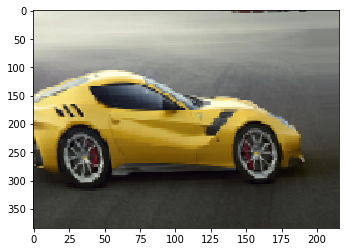

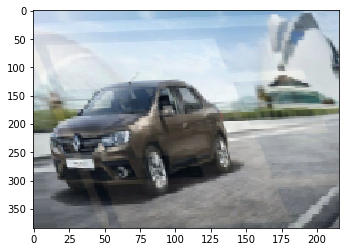

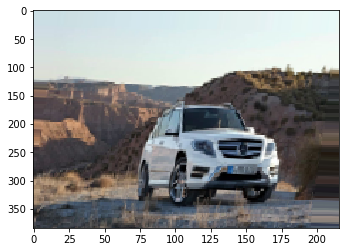

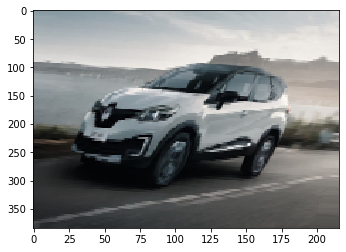

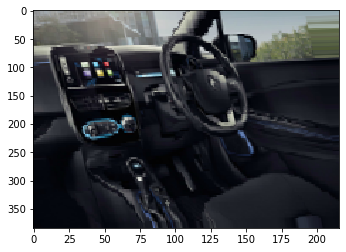

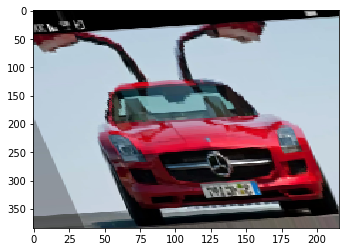

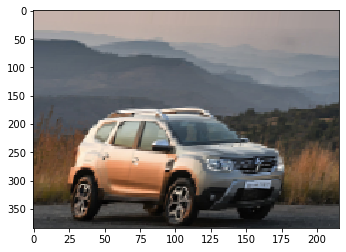

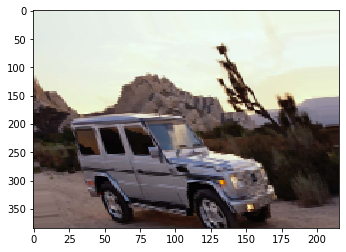

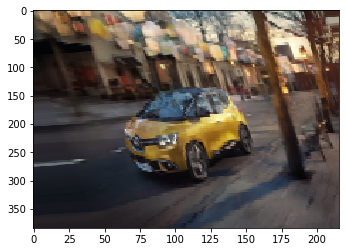

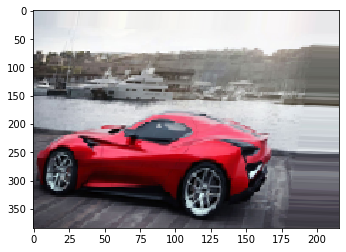

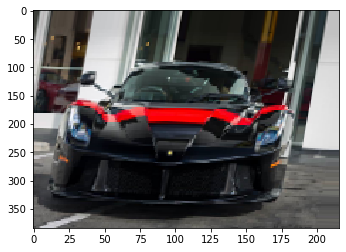

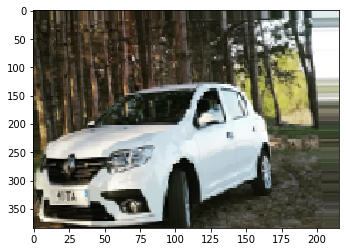

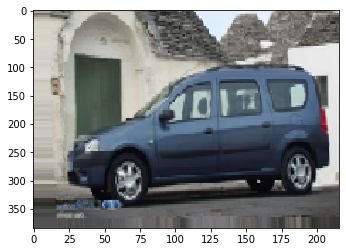

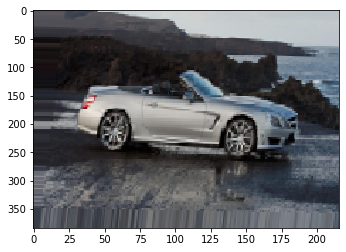

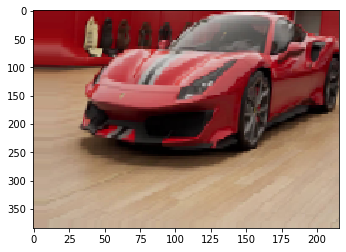

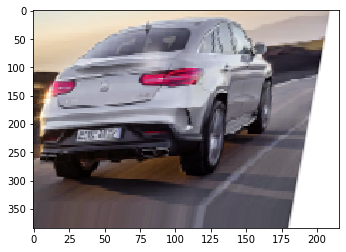

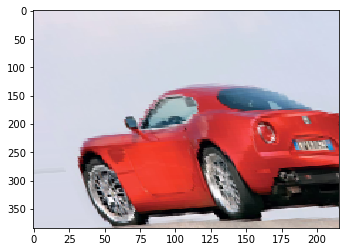

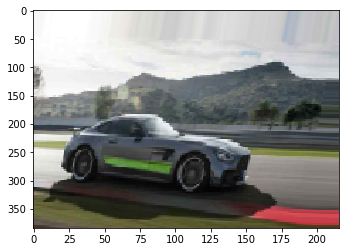

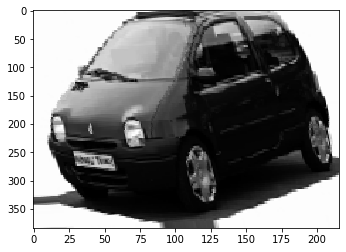

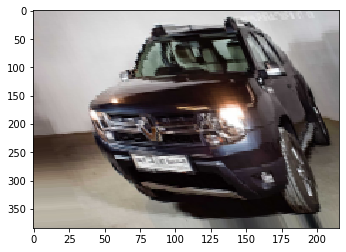

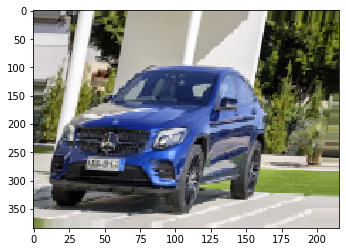

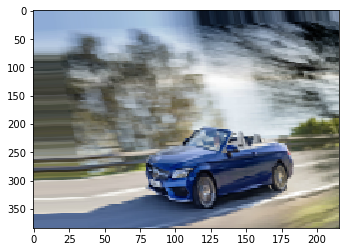

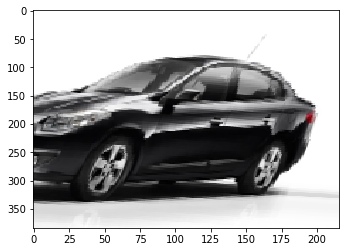

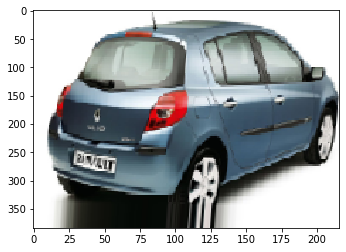

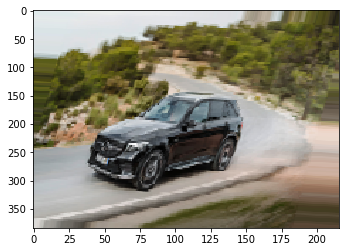

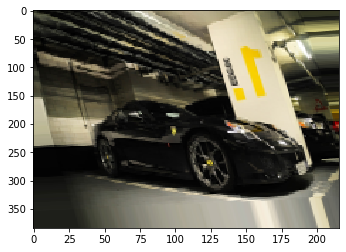

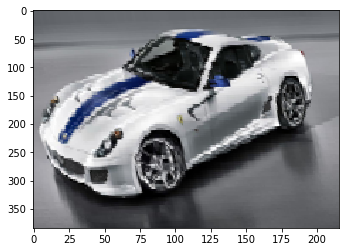

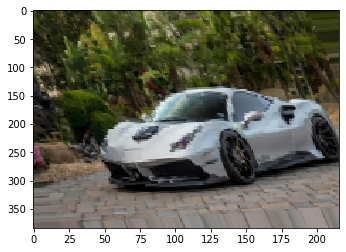

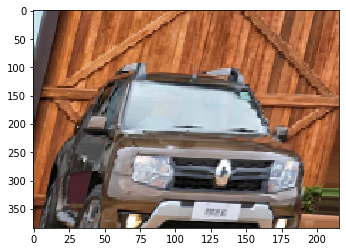

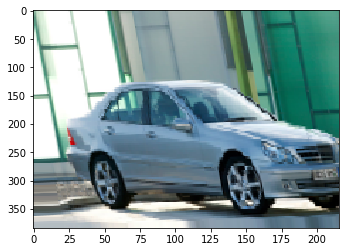

In [ ]:
def show_pics_with_indexes(arr, indexes):

    for i in indexes:  # проходим по всем классам
        img = arr[i]

        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.imshow(img, interpolation='nearest')    
        ax.set_aspect(0.4)

        plt.show()

NUM_TO_SHOW = 30
show_pics_with_indexes(x_train_full, high_err_indexes[:NUM_TO_SHOW])